In [1]:
import pandas as pd
import numpy as np
from data_providers import YahooMarketDataProvider
from datetime import datetime
import tensorflow as tf
from agent import TradingAgent
from gym_trading_env.environments import TradingEnv
import gymnasium as gym
from tqdm import tqdm
import gym_trading_env
import mlflow
import warnings
import sys
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
data_provider = YahooMarketDataProvider()

In [3]:
data_15_minutes = data_provider.get_data('BTC-USD','15m', from_date='2023-09-20', to_date='2023-11-16')
data_hourly = data_provider.get_data('BTC-USD','1h', from_date='2022-01-01', to_date='2022-12-31')
data_daily = data_provider.get_data('BTC-USD','1d', from_date='2022-01-01', to_date='2023-12-31')
data_weekly = data_provider.get_data('BTC-USD','1wk', from_date='2022-01-01', to_date='2023-12-31')

In [4]:
#training episode to use weights of 
episode_checkpoint = 330
#initial starting capital
starting_capital = 10000
# max steps per episode
max_episode_steps=100
# total episodes
max_episodes = 100
# discount factor
gamma = .99
# update frequency between online model and target model
tau =100
# Adam learning rate
learning_rate=0.0001
 # L2 regularization using norm 2 euclidian distance
l2_reg = 1e-6
# size of the prioritized replay buffer
replay_capacity = int(1e5)
# batch size to fetch from replay buffer
batch_size=4096
# epsilon greedy policy parameters
epsilon_start = 1.0
epsilon_end = .01
epsilon_decay_episodes = 0.8* max_episodes
epsilon_exponential_decay = .99
actions = [-0.5-0.1,0,0.1,0.5]


tf.keras.backend.clear_session()

def reward_function(history):
    return 800*np.log(history["portfolio_valuation", -1] / history["portfolio_valuation", -2]) #log (p_t / p_t-1 )

number_of_features = 16
window_size = 15
state_dimensions = 95

checkpoint_file_path = "checkpoints/episode-{episode:04d}/checkpoint"

trading_agent = TradingAgent(
                num_actions=4,
                learning_rate=learning_rate,
                gamma=gamma,
                epsilon_start=epsilon_start,
                epsilon_end=epsilon_end,
                epsilon_decay_episodes=epsilon_decay_episodes,
                epsilon_exponential_decay=epsilon_exponential_decay,
                replay_capacity=replay_capacity,
                l2_reg=l2_reg,
                tau=tau,
                batch_size=batch_size,
                window_size=window_size,
                number_of_features=number_of_features,
                weights_path=checkpoint_file_path.format(episode=episode_checkpoint))

In [5]:
df_dict = {"15m": data_15_minutes, "1h": data_hourly, "1d": data_daily, "1w": data_weekly}

In [6]:
comparison_dict = {
    "15m": {"date":[], "portfolio": [], "close_price": [], "position": []},
    "1h": {"date":[], "portfolio": [], "close_price": [], "position": []}, 
    "1d": {"date":[], "portfolio": [], "close_price": [], "position": []},
    "1w": {"date":[], "portfolio": [], "close_price": [], "position": []}}

In [7]:
for timeframe, df in tqdm(df_dict.items()):
    env = gym.make(
    "TradingEnv",
    name= "BTCUSD",
    df = df,
    windows= window_size,
    positions = actions,
    initial_position = 0, #Initial position
    trading_fees = 0.01/100, # 0.01% per stock buy / sell
    borrow_interest_rate= 0.0003/100, #per timestep (= 1h here)
    reward_function = reward_function,
    portfolio_initial_value = starting_capital, # in FIAT (here, USD)
    verbose=1,
    )
    
    # Run model episode
    done, truncated = False, False
    this_state = np.reshape(env.reset()[0],(window_size, number_of_features))
    while not done and not truncated:
        action_index = trading_agent.predict(this_state)
        next_state, reward, done, truncated, info = env.step(action_index)
        next_state = np.reshape(next_state,(window_size, number_of_features))
        this_state = next_state
        comparison_dict[timeframe]["date"].append(env.unwrapped.historical_info["data_date_close"][-1])
        comparison_dict[timeframe]["portfolio"].append(env.unwrapped.historical_info["portfolio_valuation"][-1])
        comparison_dict[timeframe]["close_price"].append(env.unwrapped.historical_info["data_close"][-1])
        comparison_dict[timeframe]["position"].append(env.unwrapped.historical_info["position"][-1])




 25%|██▌       | 1/4 [11:14<33:44, 674.71s/it]

Market Return : 40.19%   |   Portfolio Return :  3.18%   |   


 50%|█████     | 2/4 [36:16<38:42, 1161.32s/it]

Market Return : -64.68%   |   Portfolio Return : -37.50%   |   


 75%|███████▌  | 3/4 [38:28<11:31, 691.17s/it] 

Market Return : -14.05%   |   Portfolio Return : -31.09%   |   


100%|██████████| 4/4 [38:47<00:00, 581.80s/it]

Market Return : 76.29%   |   Portfolio Return : 69.07%   |   


In [10]:
import matplotlib.pyplot as plt


In [11]:
plot_dict = {}
plot_dict["timeframes"] = list(comparison_dict.keys())
plot_dict["model_values"] = []
for key, test in comparison_dict.items():
    plot_dict["model_values"].append((comparison_dict[key]["portfolio"][-1]-10000) / 10000)
    
    

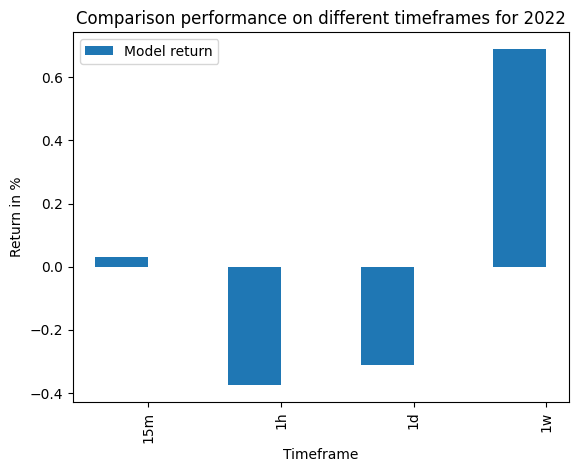

In [13]:
x_axis = np.arange(len(plot_dict["timeframes"]))

plt.bar(x_axis -0.2, plot_dict["model_values"], width=0.4, label = 'Model return')
plt.xticks(x_axis, plot_dict["timeframes"], rotation=90)
plt.xlabel("Timeframe")
plt.ylabel("Return in %")
plt.title("Comparison performance on different timeframes for 2022")
plt.legend()
plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00,  6.16it/s]


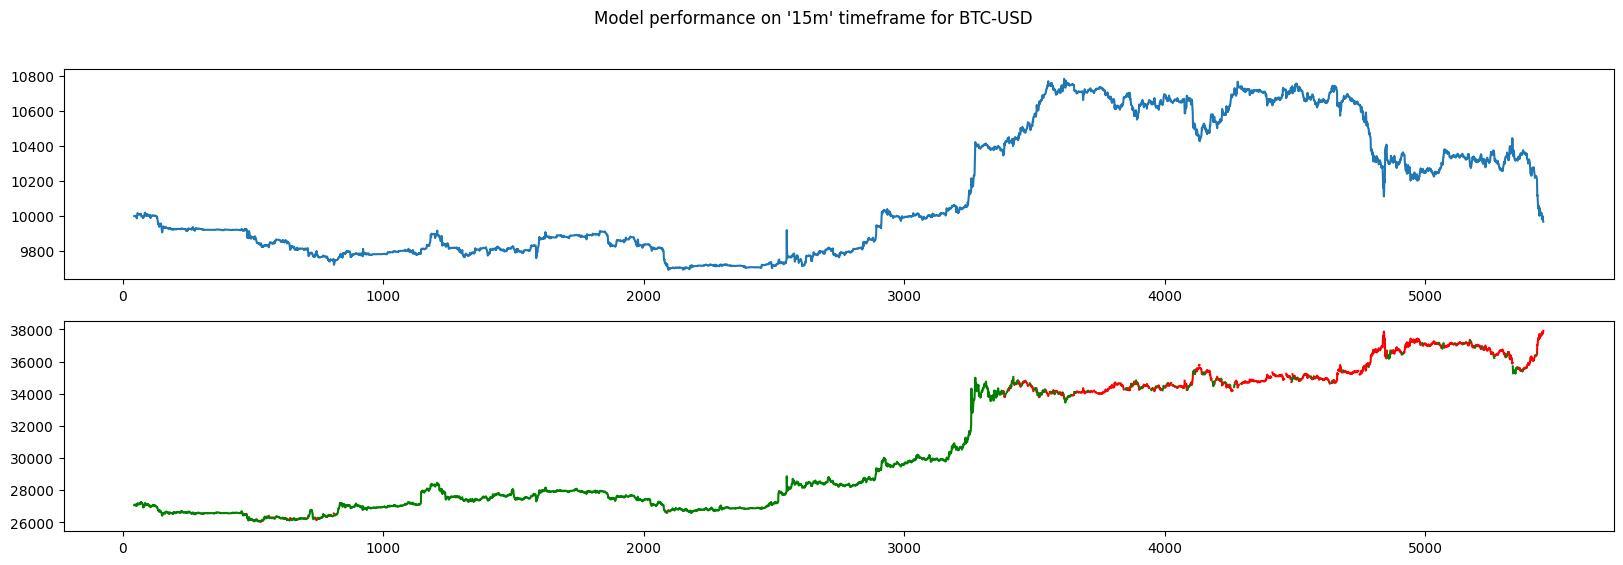

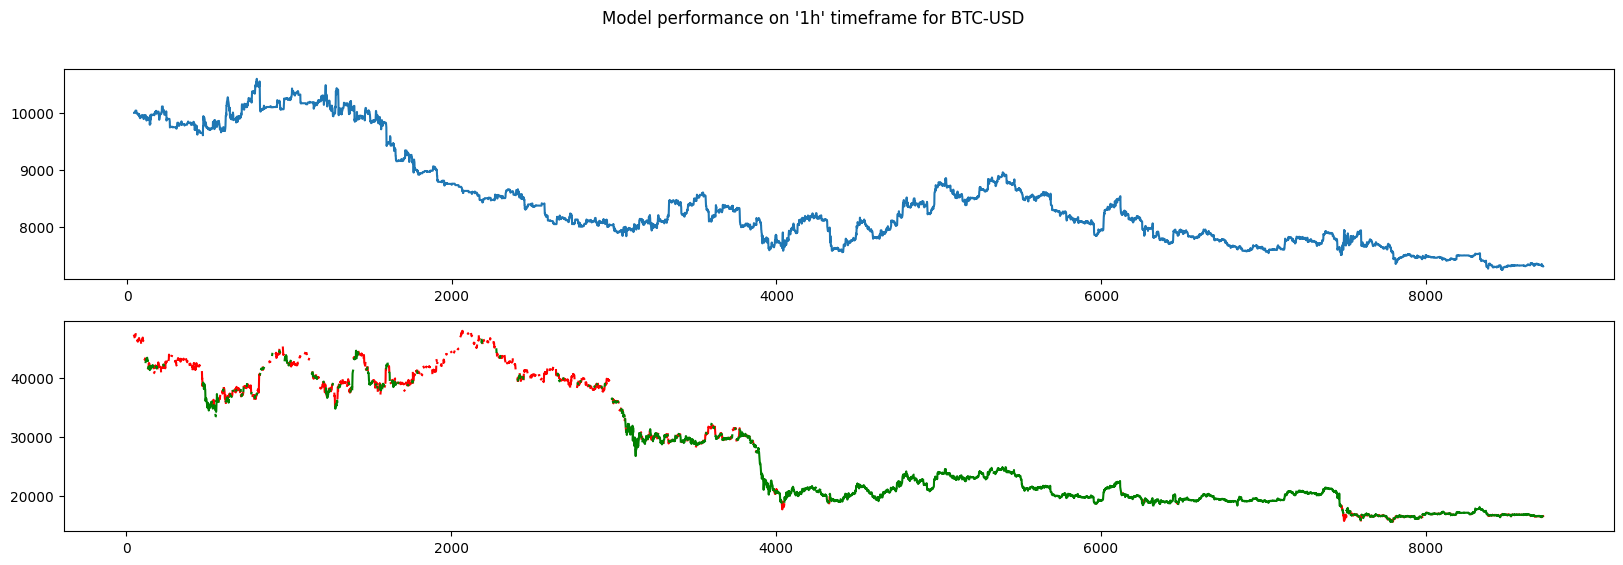

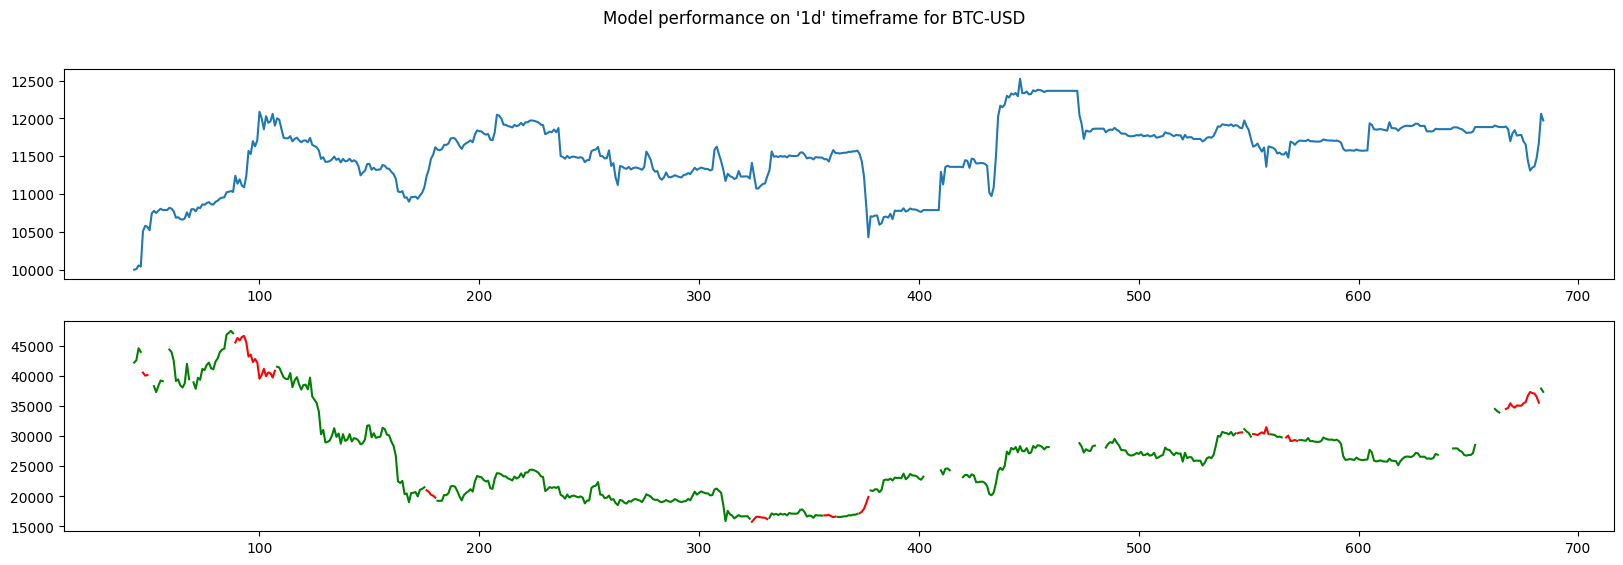

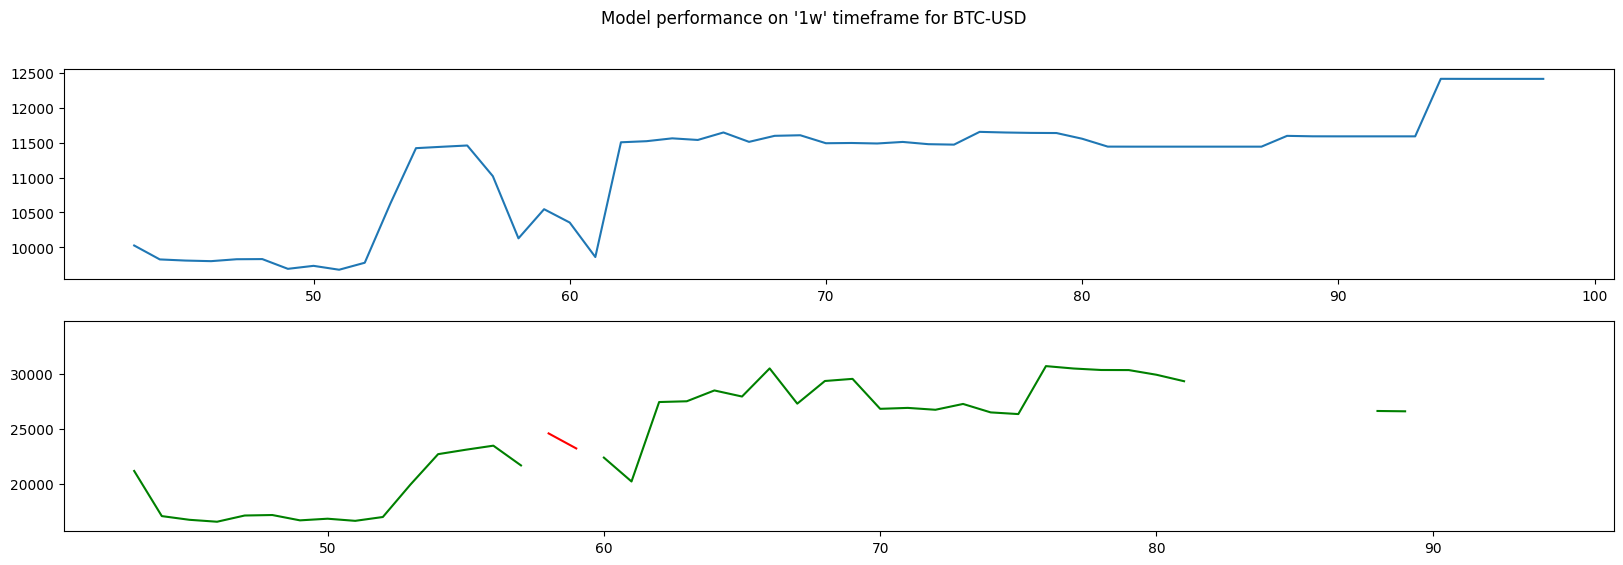

In [18]:

for timeframe, data_dict in tqdm(comparison_dict.items()):
    data_df = pd.DataFrame(data_dict)

    sell_position_df = pd.DataFrame({"close": [None] * len(data_df)})
    sell_filtered = data_df[data_df['position']<0]
    sell_position_df.close[sell_filtered.index] = sell_filtered.close_price

    buy_position_df =  pd.DataFrame({"close": [None] * len(data_df)})
    buy_filtered = data_df[data_df['position']>0]
    buy_position_df.close[buy_filtered.index] = buy_filtered.close_price

    fig, (ax1, ax2) = plt.subplots(2)
    fig.suptitle(f'Model performance on \'{timeframe}\' timeframe for BTC-USD')
    fig.set_size_inches(20,6)
    
    ax1.plot(data_dict["date"], data_dict["portfolio"])
    ax2.plot(data_dict["date"], sell_position_df.close.tolist(), color='red')
    ax2.plot(data_dict["date"], buy_position_df.close.tolist(), color='green')
    
    
    